# 🌸 Exploración del dataset Iris

Este notebook acompaña mi primer proyecto de clasificación con flores **Iris**.  
Aquí quiero mostrar cómo exploré los datos, entrené un modelo básico, probé una alternativa y guardé el modelo para usarlo después.

**Objetivos:**
- Ver cómo son los datos y entender sus características.
- Entrenar un modelo base (Regresión Logística).
- Probar un modelo alternativo (KNN).
- Analizar los errores con gráficas.
- Guardar y cargar el modelo entrenado, igual que en mis scripts de `src/`.




In [1]:
# 0) SETUP
# Aquí importo las librerías que voy a usar y fijo una semilla para que siempre me salga igual.
import sys, pathlib, warnings, numpy as np
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set()
plt.rcParams['figure.dpi'] = 110  # que los gráficos se vean más nítidos

SEED = 42
np.random.seed(SEED)  # reproducibilidad: si corro esto varias veces, me da el mismo resultado

# Accedo a las constantes que definí en src/common.py
ROOT = pathlib.Path().resolve().parent
SRC  = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

from common import FEATURE_COLUMNS, MODEL_PATH

print("Columnas:", FEATURE_COLUMNS)
print("Ruta del modelo:", MODEL_PATH)


Columnas: ['sepal_length (cm)', 'sepal_width (cm)', 'petal_length (cm)', 'petal_width (cm)']
Ruta del modelo: models/model.joblib


## 1. Cargar datos

El dataset Iris ya viene en `sklearn`, así que no necesito un CSV. Lo convierto en un DataFrame para trabajar más cómodo.


In [12]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=FEATURE_COLUMNS)
df['species'] = iris.target
target_names = iris.target_names

# veo las primeras filas
display(df.head())


,sepal_length (cm),sepal_width (cm),petal_length (cm),petal_width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 2. Estadísticas y balance de clases

Quiero ver un resumen de las columnas y cuántos datos hay por cada clase de flor.


In [13]:
# estadísticas de las columnas y si hay valores faltantes
stats = df[FEATURE_COLUMNS].describe().T
stats['missing'] = df[FEATURE_COLUMNS].isna().sum()
display(stats)

# cuántas flores hay de cada especie
counts = df['species'].value_counts().sort_index()
display(pd.DataFrame({'species': target_names, 'count': counts.values}))


,count,mean,std,min,25%,50%,75%,max,missing
sepal_length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9,0
sepal_width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4,0
petal_length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9,0
petal_width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5,0


,species,count
0,setosa,50
1,versicolor,50
2,virginica,50


## 3. Exploración visual

Me interesa ver si las clases se separan bien con gráficas sencillas.


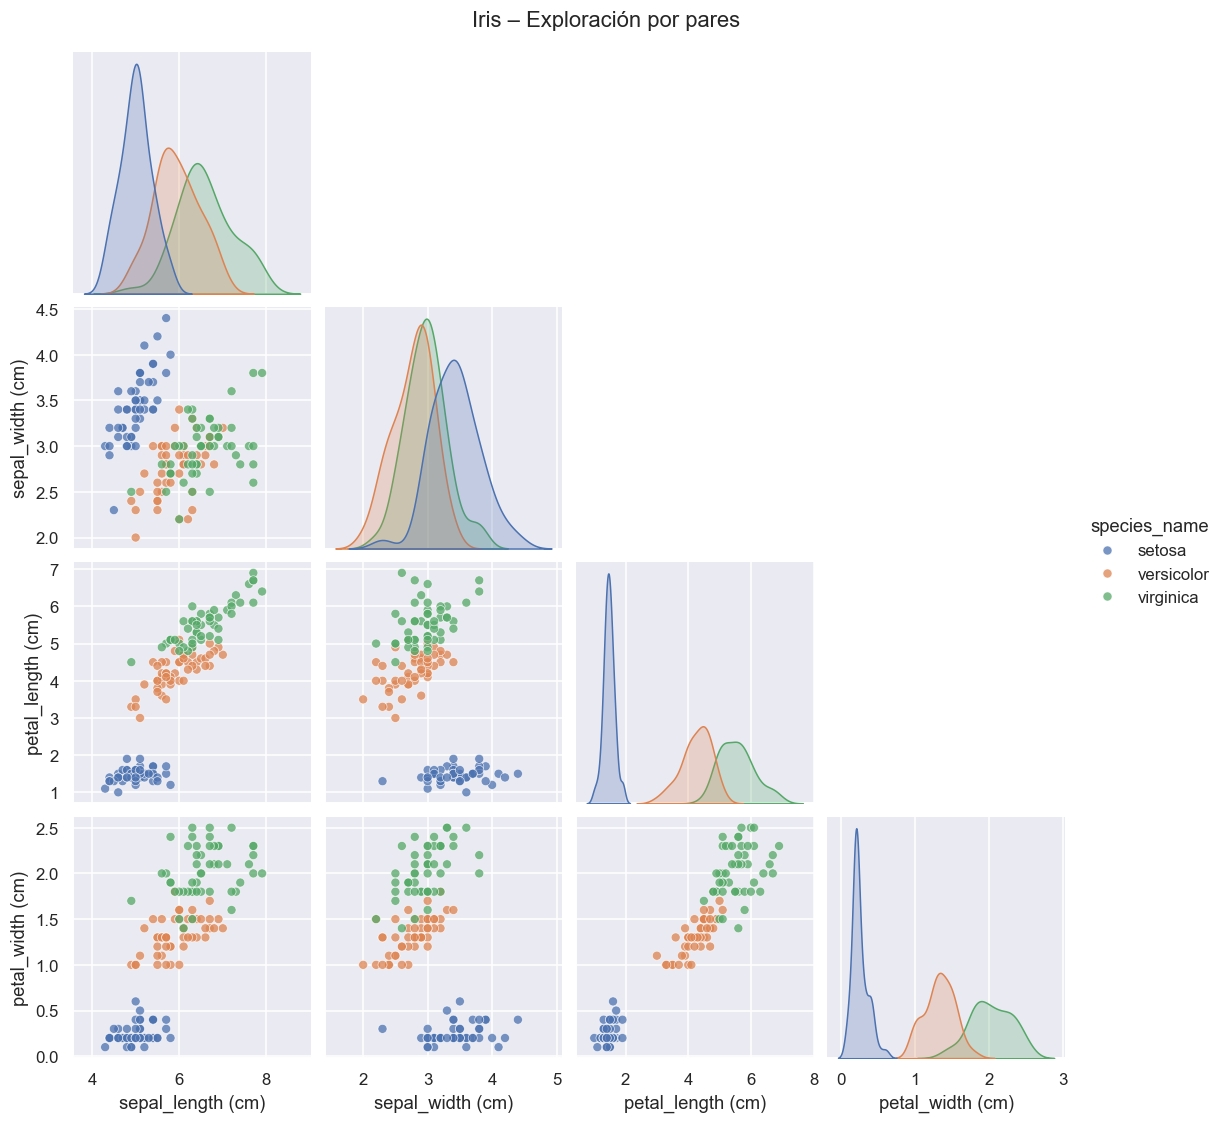

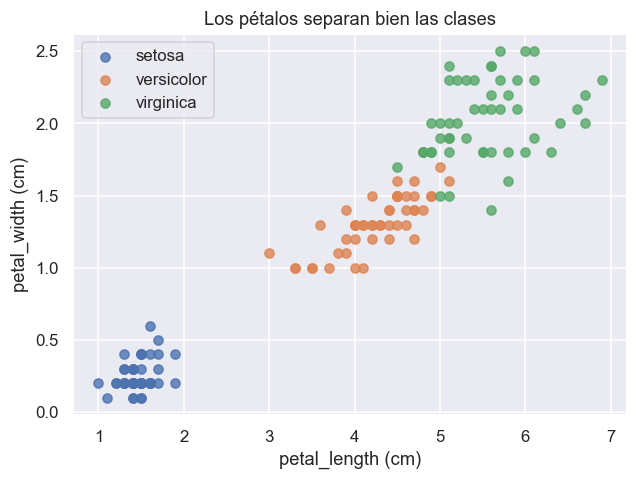

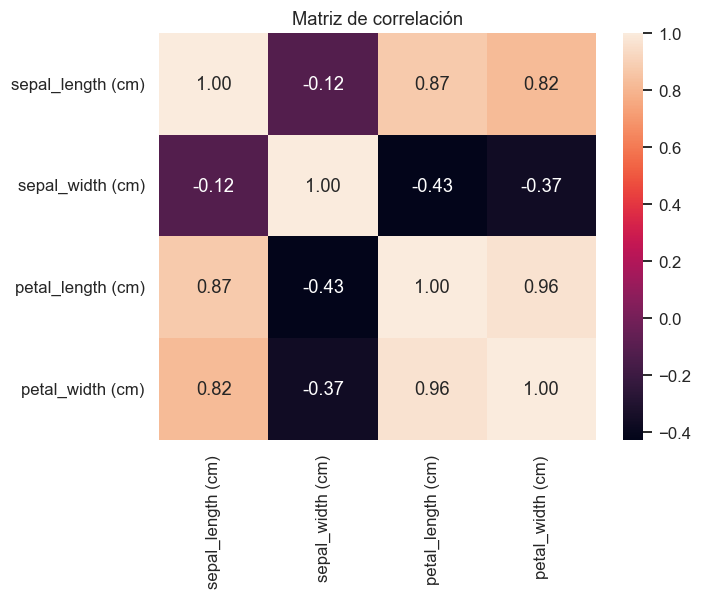

In [14]:
# pairplot para ver cómo se relacionan todas las columnas entre sí
sns.pairplot(
    df.assign(species_name=df['species'].map(dict(enumerate(target_names)))),
    vars=FEATURE_COLUMNS, hue='species_name', corner=True,
    plot_kws={'alpha':0.75, 's':35}
)
plt.suptitle("Iris – Exploración por pares", y=1.02)
plt.show()

# scatter de los pétalos (estos suelen separar mejor las clases)
plt.figure(figsize=(6.5, 4.5))
for k, name in enumerate(target_names):
    subset = df[df['species'] == k]
    plt.scatter(subset['petal_length (cm)'], subset['petal_width (cm)'], label=name, alpha=0.8)
plt.xlabel('petal_length (cm)')
plt.ylabel('petal_width (cm)')
plt.title("Los pétalos separan bien las clases")
plt.legend()
plt.show()

# correlación entre columnas
sns.heatmap(df[FEATURE_COLUMNS].corr(), annot=True, fmt='.2f')
plt.title("Matriz de correlación")
plt.show()


## 4. División de datos

Voy a separar en entrenamiento y prueba, usando `stratify=y` para que las proporciones de clases se mantengan.


In [15]:
from sklearn.model_selection import train_test_split

X = df[FEATURE_COLUMNS]
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train.shape, X_test.shape


((120, 4), (30, 4))

## 5. Modelo base: Regresión Logística

En este notebook uso un `Pipeline` con escalado para mostrar buenas prácticas.  
En `train.py` dejé el modelo directo, sin escalado, para que se vea más simple.


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte por clase:\n", classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.9333333333333333

Reporte por clase:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



### Matriz de confusión
Así veo en qué se equivoca el modelo.


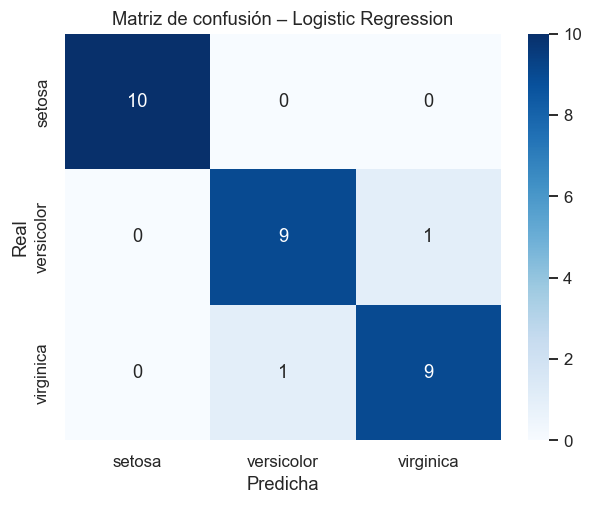

Real: setosa  ->  Pred: {np.str_('setosa'): np.int64(10), np.str_('versicolor'): np.int64(0), np.str_('virginica'): np.int64(0)}
Real: versicolor  ->  Pred: {np.str_('setosa'): np.int64(0), np.str_('versicolor'): np.int64(9), np.str_('virginica'): np.int64(1)}
Real: virginica  ->  Pred: {np.str_('setosa'): np.int64(0), np.str_('versicolor'): np.int64(1), np.str_('virginica'): np.int64(9)}


In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de confusión – Logistic Regression')
plt.ylabel("Real"); plt.xlabel("Predicha")
plt.show()

# también lo muestro en texto
for i in range(3):
    fila = cm[i]
    print(f"Real: {target_names[i]}  ->  Pred: {dict(zip(target_names, fila))}")


## 6. Comparar con KNN

Probar un modelo más me sirve para confirmar que el dataset es fácil de separar.


In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

print("Accuracy Logistic Regression:", accuracy_score(y_test, y_pred))
print("Accuracy KNN:", accuracy_score(y_test, y_knn))


Accuracy Logistic Regression: 0.9333333333333333
Accuracy KNN: 1.0


## 7. Guardar y cargar el modelo

Guardo el pipeline completo para poder reutilizarlo igual en producción.  
Luego lo cargo y hago una predicción de ejemplo.


In [19]:
import pathlib

pathlib.Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
bundle = {"model": pipe_lr, "target_names": target_names}
joblib.dump(bundle, MODEL_PATH)
print("Modelo guardado en:", MODEL_PATH)

# cargar y probar
loaded = joblib.load(MODEL_PATH)
clf   = loaded["model"]
names = loaded["target_names"]

ejemplo = [5.1, 3.5, 1.4, 0.2]
pred   = int(clf.predict(pd.DataFrame([ejemplo], columns=FEATURE_COLUMNS))[0])
print("Entrada:", ejemplo)
print("Especie predicha:", names[pred])


Modelo guardado en: models/model.joblib
Entrada: [5.1, 3.5, 1.4, 0.2]
Especie predicha: setosa


## 8. Reproducibilidad

Anoto las versiones por si alguien quiere repetir el experimento en otro entorno.


In [20]:
import sklearn, platform
print("Python:", sys.version.split()[0])
print("scikit-learn:", sklearn.__version__)
print("Platform:", platform.platform())


Python: 3.13.7
scikit-learn: 1.7.2
Platform: macOS-15.6.1-arm64-arm-64bit-Mach-O


## 9. Conclusiones

- Los **pétalos** separan mejor las clases que los sépalos (se ve en pairplot y scatter).  
- Con **Regresión Logística** ya se logra una muy buena exactitud.  
- **KNN** también funciona, lo cual confirma que el dataset es sencillo de clasificar.  
- Guardar el **pipeline completo** me asegura que el modelo se puede usar directo en los scripts.  
- Próximos pasos que me gustaría intentar:
  - Hacer validación cruzada y ajustar hiperparámetros.
  - Escribir una pequeña “model card” en el README explicando usos y límites.
  - (Opcional) Montar un endpoint con FastAPI para hacer predicciones como demo.  
